In [1]:
import numpy as np
import pandas as pd
import mysql.connector as sql
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.geocoders import Nominatim as nm
import folium as fm
from folium.plugins import MarkerCluster
from tqdm.notebook import tqdm

#%matplotlib qt


In [2]:
#IMPORTING ALL THREE DATA FRAMES 
df1 = pd.read_csv('events_data.csv')
server = sql.connect(host='cpanel.insaid.co', database='Capstone1', user='student', password='student')

df2 = pd.read_sql('SELECT * FROM gender_age_train', con=server)
df3 = pd.read_sql('SELECT * FROM phone_brand_device_model', con=server)
server.close

#ADDITIONAL REQUIRED INFO
eng_names = np.array([['华为','Huawei'],
                      ['小米','Xiaomi'],
                      ['三星','Samsung'],
                      ['vivo','vivo'],
                      ['OPPO','OPPO'],
                      ['魅族','Meizu'],
                      ['酷派','Coolpad'],
                      ['乐视','LeEco'],
                      ['联想','Lenovo'],
                      ['HTC','HTC']])

In [3]:
# Some output formatting assistance
def line_break():
    print('-------------------------------------------------------------------------------------')



# Check 1 - Whether longitude and latitude are always missing in pairs:
# This code creates two dataframes, containing the index values (row numbers) of the rows where either one is missing, and then checks if the two dataframes are identical.
# If they are identical, then they are always missing in pairs.
Check1 = df1[df1['latitude'].isnull()].index.equals(df1['longitude'].isnull().index)
print("Check 1 - Latitude and Longitude are always missing in pairs - " + str(Check1))

line_break()

# Check 2 - Whether each city only exists in one state
# This code creates a dataframe containing unique city-state pairs, and the length of this dataframe is compared to the number of unique cities.
# If they are of different length, then we cannot calculate the state using the city
city_state_pairs = df1[df1['state'].notnull()][['city','state']].drop_duplicates()
unique_cities = df1['city'].nunique()
print('Check 2 - There are ' + str(len(city_state_pairs)) + ' unique city-state pairs, and ' + str(unique_cities) + ' unique cities')
#These two numbers are not equal. This means that some cities are present in multiple states. To verify:
city_state_pairs['city'].value_counts()[0:11]

line_break()

# Check 3 - Whether we can use coordinates to find the state
Check3a = df1[df1['latitude'].isnull()].index.tolist()
Check3b = df1[df1['state'].isnull()].index.tolist()
for i in Check3a:
    if i in Check3b:
        print('Check 3 - In row ' + str(i) + ', both the coordinates and the city are missing')
# This prints nothing; therefore, we can use coordinates to find the city.
# This is foolproof, as each coordinate pair MUST refer to only one state

line_break()

# Check 4 - Keep track of number of unique entries in "state"
# After adding the states using geopy, if the syntax is wrong, then this will help detect that:
print('Check 4 - There are ' + str(df1['state'].nunique()) + ' unique entries in the "state" column.')



Check 1 - Latitude and Longitude are always missing in pairs - False
-------------------------------------------------------------------------------------
Check 2 - There are 943 unique city-state pairs, and 933 unique cities
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
Check 4 - There are 32 unique entries in the "state" column.


In [4]:
# This is a list containing the index values of all rows where state is a null value.
null_records = df1[df1['state'].isnull()].index.tolist()
# This section of code fills in those values via geopy and a loop over the rows with null values
geolocator = nm(user_agent="my-applications")
for i in null_records:
    location = geolocator.reverse([df1.at[i,'latitude'],df1.at[i,'longitude']])
    # the code for location is taken from https://www.geeksforgeeks.org/python-remove-spaces-from-a-string/
    df1.at[i,'state'] = location.raw['address'].get('state', '').replace(' ','')

print(df1['state'].nunique())

## THIS DOES THE FILTERING FOR MAHARASHTRA
df1 = df1[df1['state'] == "Maharashtra"]

32


In [5]:
# Studying the null values in the coordinates. 
# This dataframe contains only the rows with null values in the coordinates
t1 = df1[df1['longitude'].isnull()]
print(t1.info())
line_break()
# This shows the device_ids present in the records with missing coordinates. 
# For MHA, there are 3 missing ids with 21 missing coordinates each. For all-India, there are 21 missing ids with 14-22 missing coordinates each.
print(t1['device_id'].value_counts())
# This stores the unique device_ids, so we can study them across the whole database.
bad_coords_id = t1['device_id'].value_counts().index

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63 entries, 20586 to 3240304
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   event_id   63 non-null     int64  
 1   device_id  63 non-null     float64
 2   timestamp  63 non-null     object 
 3   longitude  0 non-null      float64
 4   latitude   0 non-null      float64
 5   city       63 non-null     object 
 6   state      63 non-null     object 
dtypes: float64(3), int64(1), object(3)
memory usage: 3.9+ KB
None
-------------------------------------------------------------------------------------
-7.364841e+18    21
 7.018600e+18    21
 5.115185e+18    21
Name: device_id, dtype: int64


In [6]:
# These count the number of unique coordinate pairs that the device_ids have across the whole database
# Note that each of the device_ids has one unique coordinate pair associated with it across ALL records. This means that the device was used from the same location all the time
# There are multiple hundred rows for each device_id with the coordinates present, so we can safely substitute the missing values with the device_id's coordinates.
for i in range(0,len(bad_coords_id)):
    print(df1[df1['device_id'] == bad_coords_id[i]][['latitude','longitude']].value_counts())
    print(df1[df1['device_id'] == bad_coords_id[i]][['latitude','longitude']].info())
    line_break()

latitude  longitude
18.54074  73.931944    2604
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2625 entries, 1678 to 3251982
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   2604 non-null   float64
 1   longitude  2604 non-null   float64
dtypes: float64(2)
memory usage: 61.5 KB
None
-------------------------------------------------------------------------------------
latitude   longitude
18.575747  73.926223    1894
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1915 entries, 822 to 3252657
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   1894 non-null   float64
 1   longitude  1894 non-null   float64
dtypes: float64(2)
memory usage: 44.9 KB
None
-------------------------------------------------------------------------------------
latitude   longitude
18.556741  73.88868     1864
dtype: int64
<class

In [7]:
# Doing the substitution here
for i in range(0,len(bad_coords_id)):
    values = {}
    replacement = df1[df1['device_id'] == bad_coords_id[i]][['latitude','longitude']].value_counts().index[0]
    values['latitude'] = replacement[0]
    values['longitude'] = replacement[1]
    df1[df1['device_id'] == bad_coords_id[i]] = df1.fillna(value = values)
df1.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 677168 entries, 9 to 3252946
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   event_id   677168 non-null  int64  
 1   device_id  677096 non-null  float64
 2   timestamp  677168 non-null  object 
 3   longitude  677168 non-null  float64
 4   latitude   677168 non-null  float64
 5   city       677168 non-null  object 
 6   state      677168 non-null  object 
dtypes: float64(3), int64(1), object(3)
memory usage: 57.5+ MB


In [8]:
# This takes out the 9 points outside of Maharashtra, based on folium visualization (removed that code, as it takes AGES). 
# The most eastern point of the 9 was in Kabul at ~69 longitude, so a cutoff of 72 is used here.

df1 = df1[df1['longitude'] > 72]
df1.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 677159 entries, 9 to 3252946
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   event_id   677159 non-null  int64  
 1   device_id  677087 non-null  float64
 2   timestamp  677159 non-null  object 
 3   longitude  677159 non-null  float64
 4   latitude   677159 non-null  float64
 5   city       677159 non-null  object 
 6   state      677159 non-null  object 
dtypes: float64(3), int64(1), object(3)
memory usage: 41.3+ MB


In [9]:
# Check 5 - Whether each device_id has got a unique corresponding coordinate.
# Same number of coordinate entires after dropping duplicates even if we include device_id
# This means that the above check is True
print(df1.info(show_counts = True))
print(df1[['device_id','longitude','latitude']].drop_duplicates().info())
print(df1[['device_id']].drop_duplicates().info())
print(df1[['longitude','latitude']].drop_duplicates().info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 677159 entries, 9 to 3252946
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   event_id   677159 non-null  int64  
 1   device_id  677087 non-null  float64
 2   timestamp  677159 non-null  object 
 3   longitude  677159 non-null  float64
 4   latitude   677159 non-null  float64
 5   city       677159 non-null  object 
 6   state      677159 non-null  object 
dtypes: float64(3), int64(1), object(3)
memory usage: 41.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9013 entries, 9 to 3252798
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   device_id  9010 non-null   float64
 1   longitude  9013 non-null   float64
 2   latitude   9013 non-null   float64
dtypes: float64(3)
memory usage: 281.7 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9011 entries, 9 to 3252798
Data columns (total

In [10]:
# Studying the null values in the device_ids. Yes, this is literally a duplicate of what was done for the coordinates.
# This dataframe contains only the rows with null values in device_id
t2 = df1[df1['device_id'].isnull()]
print(t2.info())
line_break()
# This shows the coordinate pairs that are present with missing device_ids. 
# Note that there are only 3 unique pairs, with 24 missing device_ids each.
print(t2[['longitude','latitude']].value_counts())
# This stores the 3 unique coordinate, so we can study them across the whole database.
bad_device_id = t2[['longitude','latitude']].value_counts().index

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72 entries, 45052 to 3135318
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   event_id   72 non-null     int64  
 1   device_id  0 non-null      float64
 2   timestamp  72 non-null     object 
 3   longitude  72 non-null     float64
 4   latitude   72 non-null     float64
 5   city       72 non-null     object 
 6   state      72 non-null     object 
dtypes: float64(3), int64(1), object(3)
memory usage: 4.5+ KB
None
-------------------------------------------------------------------------------------
longitude  latitude 
73.860165  18.566925    24
73.862756  18.628057    24
73.926499  18.614812    24
dtype: int64


In [11]:
# These take the three aforementioned coordinate pairs and counts the device_id for each pair in the full database
# Note that for each pair, only one device_id turns up
# This means that for the 24 records missing device_ids, we can assume that the same device_id is used as for the hundreds of records at that coordinate which have device_id present.
print(df1.loc[(df1['longitude'] == bad_device_id[0][0]) & (df1['latitude'] == bad_device_id[0][1])]['device_id'].value_counts())
line_break()
print(df1.loc[(df1['longitude'] == bad_device_id[1][0]) & (df1['latitude'] == bad_device_id[1][1])][['device_id']].value_counts())
line_break()
print(df1.loc[(df1['longitude'] == bad_device_id[2][0]) & (df1['latitude'] == bad_device_id[2][1])][['device_id']].value_counts())

8.539871e+18    1793
Name: device_id, dtype: int64
-------------------------------------------------------------------------------------
device_id   
9.027086e+18    1767
dtype: int64
-------------------------------------------------------------------------------------
device_id   
1.771586e+17    1698
dtype: int64


In [12]:
# Doing the substitution here
for i in range(0,3):
    replacement = df1.loc[(df1['longitude'] == bad_device_id[i][0]) & (df1['latitude'] == bad_device_id[i][1])]['device_id'].value_counts().index[0]
    (df1.loc[(df1['longitude'] == bad_device_id[i][0]) & (df1['latitude'] == bad_device_id[i][1])]) = df1.fillna(value = replacement)
df1.info(show_counts=True)
# This converts the device_id to int.
df1['device_id'] = df1['device_id'].astype('int64')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 677159 entries, 9 to 3252946
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   event_id   677159 non-null  int64  
 1   device_id  677159 non-null  float64
 2   timestamp  677159 non-null  object 
 3   longitude  677159 non-null  float64
 4   latitude   677159 non-null  float64
 5   city       677159 non-null  object 
 6   state      677159 non-null  object 
dtypes: float64(3), int64(1), object(3)
memory usage: 57.5+ MB


In [13]:
dft = pd.merge(left=df1,right=df2,how='left',on='device_id')
dfm = pd.merge(left=dft,right=df3,how='left',on='device_id')

In [72]:
# Creating better groups
# Generating a replacement list:


dfm['new_group'] = np.nan


,event_id,device_id,timestamp,longitude,latitude,city,state,gender,age,group,phone_brand,device_model,new_group
0,720049,4928555839839670272,2016-05-06 19:00:52,72.844795,18.974929,Mumbai,Maharashtra,NaN,NaN,NaN,NaN,NaN,NaN
1,13998,3978025911571213824,2016-05-06 13:12:42,73.875196,18.615791,Pune,Maharashtra,NaN,NaN,NaN,NaN,NaN,NaN
2,1378252,-4384473680693400576,2016-05-05 04:20:02,73.914179,18.619081,Pune,Maharashtra,NaN,NaN,NaN,NaN,NaN,NaN
3,185325,-7369689650429993984,2016-05-02 20:07:07,72.874552,19.014537,Mumbai,Maharashtra,NaN,NaN,NaN,NaN,NaN,NaN
4,1861432,3965810796882254848,2016-05-02 20:49:13,73.938826,18.582846,Pune,Maharashtra,NaN,NaN,NaN,NaN,NaN,NaN
5,2923724,5178607734587384832,2016-05-05 21:14:28,72.859311,18.990110,Mumbai,Maharashtra,NaN,NaN,NaN,NaN,NaN,NaN
6,1851307,4918127076064191488,2016-05-03 11:07:32,77.630324,19.990620,Pusad,Maharashtra,NaN,NaN,NaN,NaN,NaN,NaN
7,1695686,-1844275662696897792,2016-05-05 19:06:46,77.354427,21.255712,Anjangaon,Maharashtra,NaN,NaN,NaN,NaN,NaN,NaN
8,1171529,3653642617746436608,2016-05-03 07:57:10,72.838406,19.014749,Mumbai,Maharashtra,NaN,NaN,NaN,NaN,NaN,NaN
9,2523586,-7818282052440525824,2016-05-05 15:33:49,73.929706,18.623336,Pune,Maharashtra,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
x = dfm.copy()

def round_age(val, base = 2):
    return int(base * np.floor(val/base))

x['new_group'] = x['age']
x[x['new_group'].notnull()]

,event_id,device_id,timestamp,longitude,latitude,city,state,gender,age,group,phone_brand,device_model,new_group
736,1492216,-6857195135381246,2016-05-02 01:30:56,72.849357,18.973144,Mumbai,Maharashtra,M,31.0,M29-31,三星,Galaxy A7,31.0
846,1809858,-454188019495185920,2016-05-06 19:51:42,72.891650,18.974597,Mumbai,Maharashtra,M,33.0,M32-38,魅族,PRO5,33.0
1036,3226773,99479029389286800,2016-05-03 08:38:10,72.856323,19.055240,Mumbai,Maharashtra,M,41.0,M39+,华为,荣耀畅玩5X,41.0
1208,1293483,-1149999182907070464,2016-05-05 19:15:20,72.851340,19.027604,Mumbai,Maharashtra,M,34.0,M32-38,三星,G3818,34.0
1706,910928,-967151454128511232,2016-05-04 20:13:28,72.849870,19.027513,Mumbai,Maharashtra,F,50.0,F43+,小米,红米note,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
676476,818972,-454188019495185920,2016-05-05 14:37:37,72.891650,18.974597,Mumbai,Maharashtra,M,33.0,M32-38,魅族,PRO5,33.0
676487,2097465,-1149999182907070464,2016-05-01 15:48:32,72.851340,19.027604,Mumbai,Maharashtra,M,34.0,M32-38,三星,G3818,34.0
676726,2687827,-4598492899548979,2016-05-04 23:28:19,72.904222,19.012112,Mumbai,Maharashtra,M,23.0,M23-26,vivo,Xperia Z2,23.0
676808,573388,-454188019495185920,2016-05-01 10:29:43,72.891650,18.974597,Mumbai,Maharashtra,M,33.0,M32-38,魅族,PRO5,33.0


In [103]:
round_age(31)

30

In [14]:
dfm.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 677159 entries, 0 to 677158
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   event_id      677159 non-null  int64  
 1   device_id     677159 non-null  int64  
 2   timestamp     677159 non-null  object 
 3   longitude     677159 non-null  float64
 4   latitude      677159 non-null  float64
 5   city          677159 non-null  object 
 6   state         677159 non-null  object 
 7   gender        3177 non-null    object 
 8   age           3177 non-null    float64
 9   group         3177 non-null    object 
 10  phone_brand   3177 non-null    object 
 11  device_model  3177 non-null    object 
dtypes: float64(3), int64(2), object(7)
memory usage: 67.2+ MB


In [42]:
# Assessing Q1 from Week 3
# Drops duplicates based on device_id only, and then slices only the latitude and longitude from the remainder.
dfq1 = dfm.drop_duplicates(subset = 'device_id', keep = 'first')[['latitude','longitude']]

# Folium map
q1_map = fm.Map(location = [19,72],tiles = 'cartodbpositron')
# List of location coordinates
locations = list(zip(dfq1['latitude'].tolist(),dfq1['longitude'].tolist()))
# Creating a marker cluster
marker_cluster = MarkerCluster(locations)
# Adding it to the map
marker_cluster.add_to(q1_map)
# Saving the map
q1_map.save('Question_1.html')

<AxesSubplot:xlabel='phone_brand', ylabel='count'>

C:\Users\Arvind\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 19977 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Arvind\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 26143 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Arvind\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 39749 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Arvind\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 26063 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Arvind\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 21326 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Arvind\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 20026 missing 

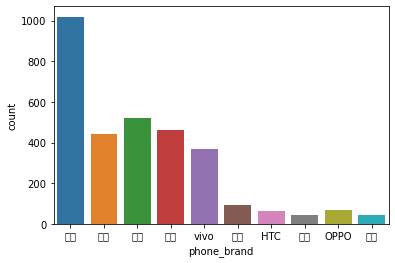

In [57]:
# Assessing Q2 from Week 3
# Creates a smaller dataframe with only rows pertaining to the 10 most common phone_brands.
dfq2 = dfm[dfm['phone_brand'].isin(dfm['phone_brand'].value_counts().index[0:10])]
sns.countplot(x='phone_brand',data=dfq2)

<AxesSubplot:xlabel='gender', ylabel='count'>

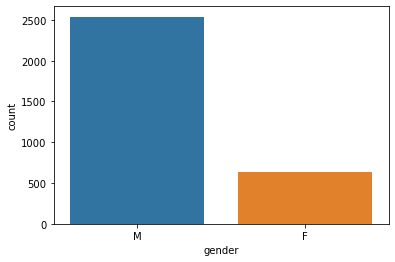

In [60]:
# Assessing Q3 from Week 3
sns.countplot(x='gender',data=dfm)

#ax = sns.barplot(x="phone_brand", y="", data=tips)

In [64]:
dfm['group'].value_counts()

M29-31    661
M27-28    597
M23-26    556
M39+      374
M32-38    351
F43+      275
F27-28    118
F29-32    118
F23-       69
F33-42     34
F24-26     24
Name: group, dtype: int64